## Deep Research

One of the classic cross-business Agentic use cases! This is huge.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">A Deep Research agent is broadly applicable to any business area, and to your own day-to-day activities. You can make use of this yourself!
            </span>
        </td>
    </tr>
</table>

In [1]:
from agents import Agent, WebSearchTool, trace, Runner, gen_trace_id, function_tool
from agents.model_settings import ModelSettings
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import asyncio
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from typing import Dict
from IPython.display import display, Markdown

In [2]:
load_dotenv(override=True)

True

## OpenAI Hosted Tools

OpenAI Agents SDK includes the following hosted tools:

The `WebSearchTool` lets an agent search the web.  
The `FileSearchTool` allows retrieving information from your OpenAI Vector Stores.  
The `ComputerTool` allows automating computer use tasks like taking screenshots and clicking.

### Important note - API charge of WebSearchTool

This is costing me 2.5 cents per call for OpenAI WebSearchTool. That can add up to $2-$3 for the next 2 labs. We'll use low cost Search tools with other platforms, so feel free to skip running this if the cost is a concern.

Costs are here: https://platform.openai.com/docs/pricing#web-search

In [3]:
INSTRUCTIONS = "You are a research assistant. Given a search term, you search the web for that term and \
produce a concise summary of the results. The summary must 2-3 paragraphs and less than 300 \
words. Capture the main points. Write succintly, no need to have complete sentences or good \
grammar. This will be consumed by someone synthesizing a report, so it's vital you capture the \
essence and ignore any fluff. Do not include any additional commentary other than the summary itself."

search_agent = Agent(
    name="Search agent",
    instructions=INSTRUCTIONS,
    tools=[WebSearchTool(search_context_size="low")],
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
)

In [4]:
message = "Latest AI Agent frameworks in 2025"

with trace("Search"):
    result = await Runner.run(search_agent, message)

display(Markdown(result.final_output))

As of July 2025, several AI agent frameworks have emerged, each offering unique capabilities for developing intelligent, autonomous systems:

- **LangChain**: A Python-based framework designed for building applications powered by large language models (LLMs). It provides tools for chaining prompts, models, memory, and external tools, facilitating the creation of complex workflows. ([medium.com](https://medium.com/%40elisowski/top-ai-agent-frameworks-in-2025-9bcedab2e239?utm_source=openai))

- **LangGraph**: An extension of LangChain, LangGraph introduces a graph-based system for managing data flow between agents. It supports branching, looping, and conditional flows, making it suitable for applications requiring complex decision-making processes. ([phyniks.com](https://phyniks.com/blog/top-7-agentic-ai-frameworks-in-2025?utm_source=openai))

- **AutoGen**: Developed by Microsoft, AutoGen focuses on multi-agent systems and code automation. It enables agents to communicate in natural language, coordinating tasks through conversation. AutoGen Studio offers a graphical interface for prototyping and testing agents. ([medium.com](https://medium.com/%40elisowski/top-ai-agent-frameworks-in-2025-9bcedab2e239?utm_source=openai))

- **CrewAI**: This framework emphasizes the orchestration of autonomous AI agents working collaboratively to achieve goals. It allows developers to define agent roles, responsibilities, and interaction styles, facilitating the creation of complex workflows where specialization and collaboration are key. ([dev.to](https://dev.to/voltagent/top-5-ai-agent-frameworks-in-2025-4gab?utm_source=openai))

- **Eliza**: A Web3-friendly AI agent operating system, Eliza integrates seamlessly with blockchain applications, enabling the deployment of AI agents in decentralized environments. It emphasizes user control and stability in its runtime implementation. ([arxiv.org](https://arxiv.org/abs/2501.06781?utm_source=openai))

- **AutoAgent**: A fully automated, zero-code framework for LLM agents, AutoAgent allows users to create and deploy AI agents through natural language alone. It operates as an autonomous agent operating system, comprising components like agentic system utilities and a self-managing file system. ([arxiv.org](https://arxiv.org/abs/2502.05957?utm_source=openai))

These frameworks reflect the rapid advancements in AI agent development, catering to a wide range of applications from complex decision-making to decentralized systems. 

### As always, take a look at the trace

https://platform.openai.com/traces

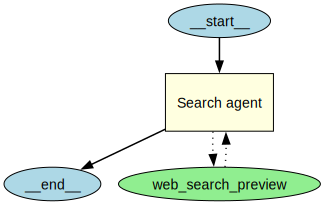

In [5]:
from agents.extensions.visualization import draw_graph
draw_graph(search_agent)

### We will now use Structured Outputs, and include a description of the fields

Okay so in the block below we setup custom structures to use for our output, instead of letting the model just output simple text like the above version. This planner agent comes up with a set of searches based on the prompt given.

In [4]:
# See note above about cost of WebSearchTool

HOW_MANY_SEARCHES = 3

INSTRUCTIONS = f"You are a helpful research assistant. Given a query, come up with a set of web searches \
to perform to best answer the query. Output {HOW_MANY_SEARCHES} terms to query for."

# Use Pydantic to define the Schema of our response - this is known as "Structured Outputs"
# With massive thanks to student Wes C. for discovering and fixing a nasty bug with this!

class WebSearchItem(BaseModel):
    reason: str = Field(description="Your reasoning for why this search is important to the query.")
    query: str = Field(description="The search term to use for the web search.")

class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem] = Field(description="A list of web searches to perform to best answer the query.")


planner_agent = Agent(
    name="PlannerAgent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=WebSearchPlan,
)

In [8]:

message = "Latest AI Agent frameworks in 2025"

with trace("Search"):
    result = await Runner.run(planner_agent, message)
    print(result.final_output)

searches=[WebSearchItem(reason='To find up-to-date information on the advancements and features of AI agent frameworks released in 2025.', query='latest AI agent frameworks 2025'), WebSearchItem(reason='To gather insights from industry experts and reports on the emerging AI agent technologies and platforms in 2025.', query='emerging AI agent technologies 2025'), WebSearchItem(reason='To review comparisons of AI agent frameworks, including performance and use cases, published in 2025.', query='comparison of AI agent frameworks 2025')]


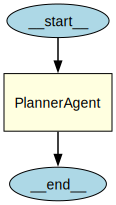

In [9]:
from agents.extensions.visualization import draw_graph
draw_graph(planner_agent)

#### At this point, we have a planning agent that creates relevant search queries for us (but does not search them) - this is what we've done above

In [ ]:
@function_tool
def send_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("kyra.nankivell@gmail.com") # Change this to your verified email
    to_email = To("emmaknankivell@gmail.com") # Change this to your email
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.send(mail)
    return {"status": "success"}

In [11]:
send_email

FunctionTool(name='send_email', description='Send out an email with the given subject and HTML body', params_json_schema={'properties': {'subject': {'title': 'Subject', 'type': 'string'}, 'html_body': {'title': 'Html Body', 'type': 'string'}}, 'required': ['subject', 'html_body'], 'title': 'send_email_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x10feec400>, strict_json_schema=True, is_enabled=True)

In [6]:
INSTRUCTIONS = """You are able to send a nicely formatted HTML email based on a detailed report.
You will be provided with a detailed report. You should use your tool to send one email, providing the 
report converted into clean, well presented HTML with an appropriate subject line."""

email_agent = Agent(
    name="Email agent",
    instructions=INSTRUCTIONS,
    tools=[send_email],
    model="gpt-4o-mini",
)

In [9]:
INSTRUCTIONS = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 5-10 pages of content, at least 1000 words."
)


class ReportData(BaseModel):
    short_summary: str = Field(description="A short 2-3 sentence summary of the findings.")
    markdown_report: str = Field(description="The final report")
    follow_up_questions: list[str] = Field(description="Suggested topics to research further")

writer_agent = Agent(
    name="WriterAgent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ReportData,
)

### The next 3 functions will plan and execute the search, using planner_agent and search_agent

In [10]:
async def plan_searches(query: str):
    """ Use the planner_agent to plan which searches to run for the query """
    print("Planning searches...")
    result = await Runner.run(planner_agent, f"Query: {query}")
    print(f"Will perform {len(result.final_output.searches)} searches")
    return result.final_output

async def perform_searches(search_plan: WebSearchPlan):
    """ Call search() for each item in the search plan """
    print("Searching...")
    tasks = [asyncio.create_task(search(item)) for item in search_plan.searches]
    results = await asyncio.gather(*tasks)
    print("Finished searching")
    return results

async def search(item: WebSearchItem):
    """ Use the search agent to run a web search for each item in the search plan """
    input = f"Search term: {item.query}\nReason for searching: {item.reason}"
    result = await Runner.run(search_agent, input)
    return result.final_output

### The next 2 functions write a report and email it

In [11]:
async def write_report(query: str, search_results: list[str]):
    """ Use the writer agent to write a report based on the search results"""
    print("Thinking about report...")
    input = f"Original query: {query}\nSummarized search results: {search_results}"
    result = await Runner.run(writer_agent, input)
    print("Finished writing report")
    return result.final_output

async def send_email(report: ReportData):
    """ Use the email agent to send an email with the report """
    print("Writing email...")
    result = await Runner.run(email_agent, report.markdown_report)
    print("Email sent")
    return report

### Showtime!

In [12]:
query ="Latest AI Agent frameworks in 2025"

with trace("Research trace"):
    print("Starting research...")
    search_plan = await plan_searches(query)
    search_results = await perform_searches(search_plan)
    report = await write_report(query, search_results)
    await send_email(report)  
    print("Hooray!")




Starting research...
Planning searches...
Will perform 3 searches
Searching...
Finished searching
Thinking about report...
Finished writing report
Writing email...
Email sent
Hooray!


### As always, take a look at the trace

https://platform.openai.com/traces

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thanks.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00cc00;">Congratulations on your progress, and a request</h2>
            <span style="color:#00cc00;">You've reached an important moment with the course; you've created a valuable Agent using one of the latest Agent frameworks. You've upskilled, and unlocked new commercial possibilities. Take a moment to celebrate your success!<br/><br/>Something I should ask you -- my editor would smack me if I didn't mention this. If you're able to rate the course on Udemy, I'd be seriously grateful: it's the most important way that Udemy decides whether to show the course to others and it makes a massive difference.<br/><br/>And another reminder to <a href="https://www.linkedin.com/in/eddonner/">connect with me on LinkedIn</a> if you wish! If you wanted to post about your progress on the course, please tag me and I'll weigh in to increase your exposure.
            </span>
        </td>
    </tr>